In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import numpy as np

from typing import Union, List, Tuple

In [2]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                            shuffle=True, num_workers=2)

Files already downloaded and verified


In [93]:
class AutoEncoder(nn.Module):
    
    def __init__(self, 
                 channels:List[int], 
                 kernel:int=4, 
                 stride:int=2, 
                 padding:int=1, 
                 conv_activation=None, 
                 out_activation=None
                ):
        
        super(AutoEncoder, self).__init__()
        
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.conv_activation = nn.SiLU if conv_activation is None else conv_activation
        
        self.encoder = self.build_coder(channels, nn.Conv2d)
        self.decoder = self.build_coder(channels[::-1], nn.ConvTranspose2d)
        self.out_activation = out_activation()
        
    def build_coder(self, channels, conv_layer):
        channel_pairs = zip(channels[:-1], channels[1:])
        coder_steps = [(
            conv_layer(i, o, self.kernel, self.stride, self.padding),
            nn.BatchNorm2d(o),
            self.conv_activation())
            for i, o in channel_pairs]
        coder_steps = [step for substep in coder_steps for step in substep][:-1] # flatten and remove last activation
        return nn.Sequential(*coder_steps)
        
    
    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        if self.out_activation:
            out = self.out_activation(out)
        return out, h
    
m = AutoEncoder([3, 10, 20, 40, 80], out_activation=nn.Sigmoid)
x = torch.randn(1,3,256,256)
m

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(40, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(80, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): ConvTranspose2d(40, 20, kernel_

In [106]:
model = AutoEncoder([3, 6, 8], out_activation=nn.Sigmoid)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1
pbar = tqdm(total=epochs * len(trainloader))
losses = []

for e in range(epochs):
    for i, (inputs, _) in enumerate(trainloader, 0):
        pbar.update(1)
        out, encoded = model(inputs)
        
        loss = criterion(out, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_description(desc=f"Epoch {e+1}/{epochs} | average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")


  0%|          | 0/3125 [00:00<?, ?it/s]

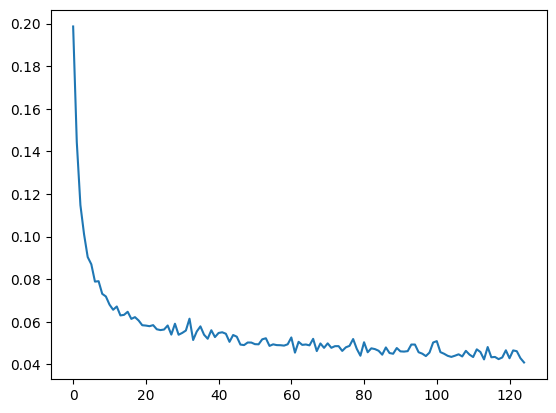

In [40]:
plt.plot(torch.tensor(losses).view(-1, 25).mean(1))

In [36]:
batch = next(iter(trainloader))
image = batch[0][0]
image.shape

torch.Size([3, 32, 32])

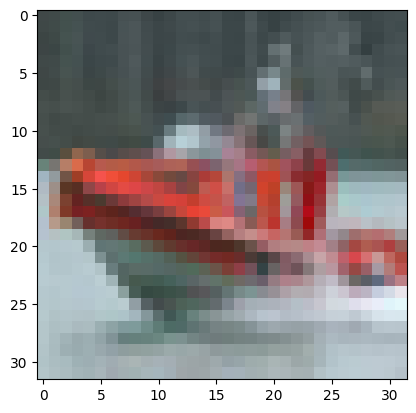

In [85]:
def imshow(img):
  #img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()
    
imshow(image)

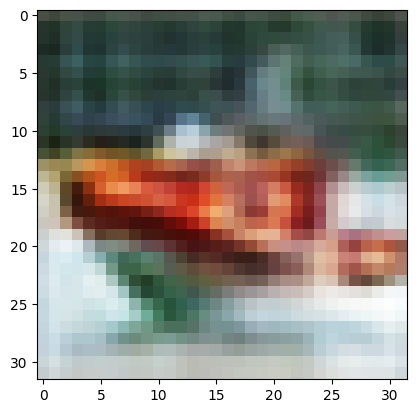

In [107]:
out, h = model(image[None,...])
imshow(out[0].squeeze().detach())

In [108]:
hidden_size = h.shape[1]*h.shape[2]*h.shape[3]
full_size = image.shape[0]*image.shape[1]*image.shape[2]
hidden_size, full_size, 1 - hidden_size / full_size

(512, 3072, 0.8333333333333334)

In [194]:
class VAE(nn.Module):
    
    def __init__(self,
                 input_dims:int,
                 hidden_dims:int,
                 bottleneck_dims:int,
                 convolutions:List[Tuple[int,int,int]]=None, 
                 conv_activation=None, 
                 out_activation=None
                ):
        
        '''
        Variational Auto Encoder
        
        Attributes
        ----------
        
        input_dims : int 
            number of input channel dimensions
        hidden_dims : int
            number of channel dimensions for hidden layers
        bottleneck_dims : int
            channel dimensions at bottelneck
        convolutions : List[Tuple[int,int,int]] (optional)
            list of tuples for convolution layers, of the form (kernel size, stride, padding)
        conv_activation (optional)
            class of the activation to be used for actvations between convolutional layers.  Defaults to SiLU
        out_activation (optional)
            class of the activation to be used after final step of the deocder.  If not set, no activation will be used.
        '''
        
        super(VAE, self).__init__()

        if convolutions is None:
            convolutions = [
                (4, 2, 1),
                (4, 2, 1),
                (5, 1, 0),
                (3, 1, 0)
            ]
            
        if conv_activation is None:
            conv_activation = nn.SiLU
        
        # build encoder
        
        encoder_steps = []
        for i, (k, s, p) in enumerate(convolutions):
            in_dim = input_dims if i == 0 else hidden_dims
            out_dim = (bottleneck_dims * 2) if i == len(convolutions) - 1 else hidden_dims
            encoder_steps.append(nn.Conv2d(in_dim, out_dim, k, s, p))
            encoder_steps.append(nn.BatchNorm2d(out_dim))
            # no activation on last layer
            if i != len(convolutions) - 1:
                encoder_steps.append(conv_activation())
        
        self.encoder = nn.Sequential(*encoder_steps)
        
        # build decoder
        
        decoder_steps = []
        for i, (k, s, p) in enumerate(convolutions[::-1]):
            in_dim = (bottleneck_dims * 2) if i == 0 else hidden_dims
            out_dim = input_dims if i == len(convolutions) - 1 else hidden_dims
            decoder_steps.append(nn.ConvTranspose2d(in_dim, out_dim, k, s, p))
            decoder_steps.append(nn.BatchNorm2d(out_dim))
            # no activation on last layer
            if i != len(convolutions) - 1:
                decoder_steps.append(conv_activation())
        
        self.decoder = nn.Sequential(*decoder_steps)
        
        if out_activation:
            self.out_activation = out_activation()
            
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        
        h_dist = torch.distributions.Normal(mu, logvar.mul(.5).exp())
        reference_dist = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_loss = torch.distributions.kl_divergence(h_dist, reference_dist).sum(dim=1).mean()
        
        out = self.decoder(h)
        if self.out_activation:
            out = self.out_activation(out)
        
        return out, kl_loss
            
            
model = VAE(3, 6, 8, out_activation=nn.Tanh)
x = torch.randn(1, 3, 100, 100)
out, kl_loss = model(x)
out.shape, kl_loss

(torch.Size([1, 3, 100, 100]), tensor(6.6003, grad_fn=<MeanBackward0>))

In [178]:
preproc_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                            download=True, transform=preproc_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                            shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
convs = [(4,2,1)]*5
model = VAE(3, 64, 512, convolutions=convs, conv_activation=nn.SiLU, out_activation=nn.ReLU)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1
pbar = tqdm(total=epochs * len(trainloader))
losses = []
kl_coeff = 0.1

for e in range(epochs):
    for i, (inputs, _) in enumerate(trainloader, 0):
        pbar.update(1)
        out, kl_loss = model(inputs)
        
        recon_loss = criterion(out, inputs)
        #loss = (kl_loss* kl_coeff) + recon_loss
        loss = recon_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_description(desc=f"Epoch {e+1}/{epochs} | average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")


  0%|          | 0/3125 [00:00<?, ?it/s]

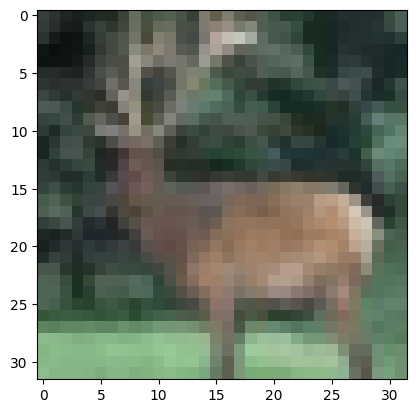

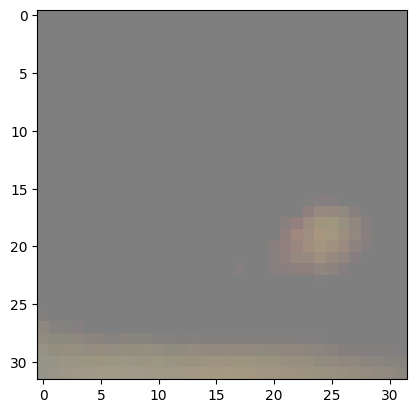

In [254]:
model.train(False)
def imshow(img, un=True):
    if un:
        img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


image = next(iter(trainloader))[0][0]
imshow(image)
out, kl_loss = model(image[None,...])
imshow(out[0].squeeze().detach())

In [247]:
model.train(False)
model.encoder(image[None,...]).squeeze()[:6]

tensor([ 1.5528, -0.4996, -0.8083,  0.5439,  1.0995,  0.1787],
       grad_fn=<SliceBackward0>)